In [1]:
from pycocotools.coco import COCO
import torch.optim as optim
import fasttext
from datetime import datetime
#from torch.utils.tensorboard import SummaryWriter
from torch.autograd import grad

import torch
import torch.nn as nn
import torch.utils.data
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors
from skimage import io
from math import sin, cos, pi

from model import *
import torchvision.utils as vutils

/home/birdy/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
path = "/home/birdy/code/master-thesis/"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
keypoint_threshold = 7

"""  
start_from_epoch = 1
torch.save(modelA.state_dict(), path +"testModel" + '_' + f'{start_from_epoch:05d}')

modelB = ModelA()
if start_from_epoch > 0:
    modelB.load_state_dict(torch.load(path +"testModel" + '_' + f'{start_from_epoch:05d}'), False)"""

'  \nstart_from_epoch = 1\ntorch.save(modelA.state_dict(), path +"testModel" + \'_\' + f\'{start_from_epoch:05d}\')\n\nmodelB = ModelA()\nif start_from_epoch > 0:\n    modelB.load_state_dict(torch.load(path +"testModel" + \'_\' + f\'{start_from_epoch:05d}\'), False)'

In [3]:
# a dataset that constructs heatmaps and optional matching caption encodings tensors on the fly
class HeatmapDataset(torch.utils.data.Dataset):
    # a dataset contains keypoints and captions, can add sentence encoding
    def __init__(self, coco_keypoint, coco_caption, single_person=False, text_model=None, full_image=False,
                 for_regression=False):

        # get all containing 'person' image ids
        image_ids = coco_keypoint.getImgIds()

        self.with_vector = (text_model is not None)
        self.for_regression = for_regression
        if for_regression:
            full_image = False
        self.full_image = full_image
        self.dataset = []

        for image_id in image_ids:
            keypoint_ids = coco_keypoint.getAnnIds(imgIds=image_id)
            if len(keypoint_ids) > 0 and ((single_person and len(keypoint_ids) == 1) or (not single_person)):
                caption_ids = coco_caption.getAnnIds(imgIds=image_id)
                captions = coco_caption.loadAnns(ids=caption_ids)
                keypoints = coco_keypoint.loadAnns(ids=keypoint_ids)

                if full_image:
                    data = {'keypoints': [], 'caption': captions.copy(),
                            'image': coco_keypoint.loadImgs(image_id)[0]}
                    for keypoint in keypoints:
                        if keypoint.get('num_keypoints') > keypoint_threshold:
                            data['keypoints'].append(keypoint.copy())
                    if len(data['keypoints']) == 0:
                        continue

                    # add sentence encoding
                    if text_model is not None:
                        data['vector'] = [get_caption_vector(text_model, caption.get('caption')) for caption in
                                          captions]
                    self.dataset.append(data)
                else:
                    # each person in the image
                    for keypoint in keypoints:
                        # with enough keypoints
                        if keypoint.get('num_keypoints') > keypoint_threshold:
                            data = {'keypoint': keypoint.copy(), 'caption': captions.copy(),
                                    'image': coco_keypoint.loadImgs(image_id)[0]}

                            # add sentence encoding
                            if text_model is not None:
                                data['vector'] = [get_caption_vector(text_model, caption.get('caption')) for caption in
                                                  captions]
                            self.dataset.append(data)

    def __len__(self):
        return len(self.dataset)

    # return either individual heatmap of heatmap of a whole image
    def get_heatmap(self, data, augment=True):
        if self.full_image:
            return get_full_image_heatmap(data.get('image'), data.get('keypoints'), augment)
        else:
            return get_heatmap(data.get('keypoint'), augment)

    def __getitem__(self, index):
        data = self.dataset[index]
        item = dict()

        if self.for_regression:
            item['coordinates'] = torch.tensor(get_augmented_coordinates(data.get('keypoint')), dtype=torch.float32)
        else:
            # change heatmap range from [0,1] to[-1,1]
            item['heatmap'] = torch.tensor(self.get_heatmap(data) * 2 - 1, dtype=torch.float32)

        if self.with_vector:
            # randomly select from all matching captions
            item['vector'] = torch.tensor(random.choice(data.get('vector')), dtype=torch.float32)
            if not self.for_regression:
                item['vector'].unsqueeze_(-1).unsqueeze_(-1)
        return item

    # get a batch of random caption sentence vectors from the whole dataset
    def get_random_caption_tensor(self, number):
        vector_tensor = torch.empty((number, sentence_vector_size), dtype=torch.float32)

        if self.with_vector:
            for i in range(number):
                # randomly select from all captions
                vector = random.choice(random.choice(self.dataset).get('vector'))
                vector_tensor[i] = torch.tensor(vector, dtype=torch.float32)

        if self.for_regression:
            return vector_tensor
        else:
            return vector_tensor.unsqueeze_(-1).unsqueeze_(-1)

    # get a batch of random heatmaps and captions from the whole dataset
    def get_random_heatmap_with_caption(self, number):
        caption = []
        heatmap = torch.empty((number, total_keypoints, heatmap_size, heatmap_size), dtype=torch.float32)

        for i in range(number):
            # randomly select from all images
            data = random.choice(self.dataset)
            heatmap[i] = torch.tensor(self.get_heatmap(data, augment=False) * 2 - 1, dtype=torch.float32)
            caption.append(random.choice(data.get('caption')).get('caption'))

        return {'heatmap': heatmap, 'caption': caption}

    # get a batch of random coordinates and captions from the whole dataset
    def get_random_coordinates_with_caption(self, number):
        caption = []
        coordinates = torch.empty((number, total_keypoints * 3), dtype=torch.float32)

        for i in range(number):
            # randomly select from all images
            data = random.choice(self.dataset)
            coordinates[i] = torch.tensor(get_augmented_coordinates(data.get('keypoint')), dtype=torch.float32)
            caption.append(random.choice(data.get('caption')).get('caption'))

        return {'coordinates': coordinates, 'caption': caption}

    # get a batch of random interpolated caption sentence vectors from the whole dataset
    def get_interpolated_caption_tensor(self, number):
        vector_tensor = torch.empty((number, sentence_vector_size), dtype=torch.float32)

        if self.with_vector:
            for i in range(number):
                # randomly select 2 captions from all captions
                vector = random.choice(random.choice(self.dataset).get('vector'))
                vector2 = random.choice(random.choice(self.dataset).get('vector'))

                # interpolate caption sentence vectors
                interpolated_vector = beta * vector + (1 - beta) * vector2
                vector_tensor[i] = torch.tensor(interpolated_vector, dtype=torch.float32)

        if self.for_regression:
            return vector_tensor
        else:
            return vector_tensor.unsqueeze_(-1).unsqueeze_(-1)

In [4]:
caption_path = '/home/birdy/datasets/coco/annotations/captions_train2017.json'
keypoint_path = '/home/birdy/datasets/coco/annotations/person_keypoints_train2017.json'
text_model_path = '/home/birdy/amazon_review_polarity.bin'
text_model = fasttext.load_model(text_model_path)


In [5]:
multi = False
coco_caption = COCO(caption_path)
coco_keypoint = COCO(keypoint_path)
dataset = HeatmapDataset(coco_keypoint, coco_caption, single_person=not multi, text_model=text_model, full_image=multi)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)


loading annotations into memory...
Done (t=1.23s)
creating index...
index created!
loading annotations into memory...
Done (t=13.41s)
creating index...
index created!


/home/birdy/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


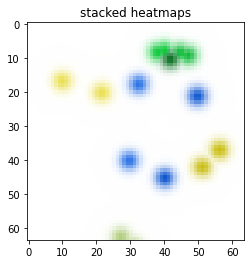

In [16]:
real_batch = next(iter(data_loader))

toBeDisplay0 = np.array(real_batch['heatmap'][0].tolist()) * 0.5 + 0.5 
plot_heatmap(toBeDisplay0, only_skeleton=True)

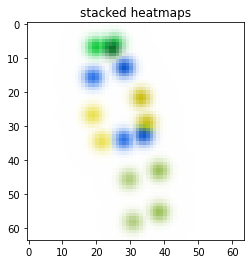

In [13]:
toBeDisplay1 = np.array(real_batch['heatmap'][1].tolist()) * 0.5 + 0.5 
plot_heatmap(toBeDisplay1)

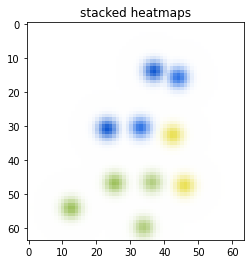

In [14]:
toBeDisplay2 = np.array(real_batch['heatmap'][2].tolist()) * 0.5 + 0.5 
plot_heatmap(toBeDisplay2)

TypeError: Invalid shape (16, 64, 64) for image data

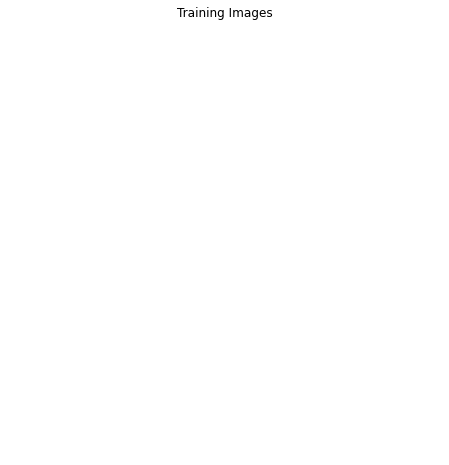

In [24]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(toBeDisplay, padding=2, normalize=True).cpu(),(0,1,2)))

In [ ]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))